In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# 파일 불러오기
데이터 출처 - https://cseweb.ucsd.edu/~jmcauley/datasets.html#multi_aspect

1. 행간이 "\n" 으로 구분된 ".json" file 업로드 (```pd.read_json```)
2. 결측치 1개 제거 (마지막행이 업로드시 이슈가 발생하는 것 같다) (```pd.DataFrame.dropna()```)

In [2]:
ratebeer = pd.read_json("../data/new_ratebeer.json", lines=True).dropna()

# 데이터 탐색

## 변수 설명
참고자료 - https://www.ratebeer.com/Story.asp?StoryID=292

- `beer/name`: 맥주 이름(상표)
- `beer/beerId`: 맥주 일련번호(코드)
- `beer/brewerId`: 맥주 생산자 일련번호
- `beer/ABV`: 맥주 알코올 도수(Alcohol by volume, %)
- `beer/style`: 맥주 카테고리
- `review/appearance`: 평가점수-외관(look) 
- `review/aroma`: 평가점수-향기(smell)
- `review/palate`: 평가점수-the sense of taste(feel)
- `review/taste`: 평가점수-맛
- `review/overall`: 평가점수-종합
- `review/time`: 평가 시간
- `review/profileName`: 유저ID
- `review/text`: 리뷰 코멘트
  
  



In [3]:
ratebeer.head(3)

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,John Harvards Simcoe IPA,63836,8481.0,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,3/5,6/10,13/20,1.157587e+09,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481.0,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,4/5,7/10,13/20,1.157242e+09,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481.0,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,9.586944e+08,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."


In [4]:
n_data, n_var = ratebeer.shape
print('[ratebeer] 데이터 길이 : ',format(n_data, ','))
print('[ratebeer] 변수 개수  : ', format(n_var, ','))

[ratebeer] 데이터 길이 :  2,924,163
[ratebeer] 변수 개수  :  13


In [5]:
# 표면상 데이터 결측치 확인
ratebeer.isna().sum()

beer/name             0
beer/beerId           0
beer/brewerId         0
beer/ABV              0
beer/style            0
review/appearance     0
review/aroma          0
review/palate         0
review/taste          0
review/overall        0
review/time           0
review/profileName    0
review/text           0
dtype: int64

### beer/name - 맥주 이름 (상표) 탐색

In [6]:
# beer/name 맥주 이름 (상표) 탐색
n_item = ratebeer['beer/name'].nunique()
print(f"[ratebeer] 맥주의 종류: {n_item:,}가지")
# print(f"[ratebeer] 맥주의 스타일 종류: {ratebeer['beer/style'].nunique():,}")

# beer/beerId 와의 관계
n_itemId = ratebeer['beer/beerId'].nunique() # 개념상 개수가 같아야하는데, `beer/beerId`가 조금 더 많다. Why?
print(f"[ratebeer] 맥주의 일련번호: {n_itemId:,}가지")


[ratebeer] 맥주의 종류: 110,299가지
[ratebeer] 맥주의 일련번호: 110,369가지


In [7]:
# 맥주의 개수와 맥주의 일련 번호가 1대1 대응이 아닙니다!

In [8]:
# 포함관계 확인;  (가정) beer/name 개수가 더 적기 때문에, 더 상위의 개념일 것이다. 
# 1 대 1 관계에 있는 맥주이름-맥주ID 개수
item_1to1 = sum(ratebeer.groupby("beer/name")["beer/beerId"].nunique() == 1)
print(f">>> 1 대 1 관계에 있는 맥주이름-맥주ID 개수: {item_1to1:7,}")

# 1 대 N 관계에 있는 맥주이름-맥주ID 개수
item_1toN = sum(ratebeer.groupby("beer/name")["beer/beerId"].nunique() != 1)
print(f">>> 1 대 N 관계에 있는 맥주이름-맥주ID 개수: {item_1toN:7,}")

print()
print("하나의 맥주 이름(beer/name)에 ")
for i, value in ratebeer.groupby("beer/name")["beer/beerId"].nunique().value_counts().iteritems():
    print(f"- {i} 개의 맥주 일련번호가 존재하는 맥주는 {value:7,} 개 이다.")

>>> 1 대 1 관계에 있는 맥주이름-맥주ID 개수: 110,231
>>> 1 대 N 관계에 있는 맥주이름-맥주ID 개수:      68

하나의 맥주 이름(beer/name)에 
- 1 개의 맥주 일련번호가 존재하는 맥주는 110,231 개 이다.
- 2 개의 맥주 일련번호가 존재하는 맥주는      66 개 이다.
- 3 개의 맥주 일련번호가 존재하는 맥주는       2 개 이다.


In [9]:
# 68개에 해당하는 맥주에 대해서 탐사해볼필요가 있다. -> ratebeer에서 직접 탐사해보자 (검색ㄱ)

In [10]:
double_id_list = ratebeer.groupby("beer/name")["beer/beerId"].nunique().where(lambda x: x >= 2).dropna().index.to_list()
print(f"여러개의 일련번호를 가지고 있는 맥주 15개의 예시 ---------------")
ratebeer[ratebeer["beer/name"].isin(double_id_list[:15])].groupby("beer/name")["beer/beerId"].unique()


여러개의 일련번호를 가지고 있는 맥주 15개의 예시 ---------------


beer/name
Alcatraz Big House Red                             [1597, 114783]
Alcatraz Octoberfest                              [18251, 114787]
Alcatraz Penitentiary Porter                      [19706, 114788]
BFM Cuve du 10me                                   [95584, 82831]
Bayerischer Hof Dunkel                           [142286, 123141]
Best Bier                                         [18102, 133877]
Big Horn Saison                                   [119890, 19336]
Brewers Art House Pale Ale                         [42980, 11026]
Broyarde l`Eclipse              [80766, broyarde-l`eclipse-80766]
Broyarde l`Harfang              [broyarde-l`harfang-80769, 80769]
Carling Black Label                                [6447, 116441]
Empire Imperial Stout                              [6053, 129883]
Falter Weissbier Dunkel                           [154890, 73417]
Fat Cat Honey Ale                                 [161761, 64273]
Freedom Organic Lager                              [58913, 15345]


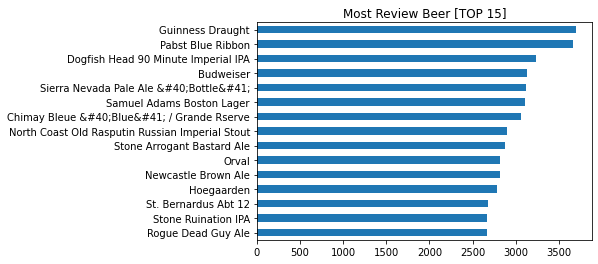

In [11]:
# 어떤 맥주가 리뷰 횟수가 많을까? 상위 15개의 맥주만 한 번 뽑아보자.
ratebeer['beer/name'].value_counts()[:15][::-1].plot(kind = 'barh')
plt.title("Most Review Beer [TOP 15]")
plt.show()

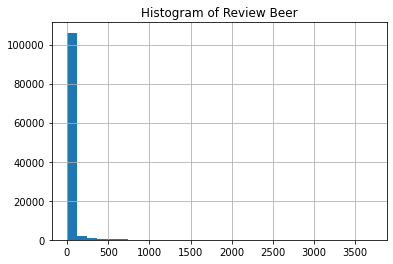

In [12]:
# 맥주 리뷰 횟수의 분포를 확인해보자
ratebeer['beer/name'].value_counts().hist(bins=30)
plt.title("Histogram of Review Beer")
plt.show()

In [13]:
# 거의 대부분의 맥주가 리뷰 횟수가 적다. -> 대부분의 맥주는 잘 조회되지 않는다. 

In [14]:
# 그렇다면, 리뷰 개수가 적은 맥주는 몇 개나 있을까? 

print(f"* 해당 데이터 안에서 존재하는 맥주의 총 가지 수  = {n_item:,}", end="\n\n")
for index, value in ratebeer['beer/name'].value_counts().value_counts().items():
    # print(index, value)
    print(f"리뷰 개수가 {index:3,} 개인 맥주의 가지 수 = {value:6,} 가지")
    if index >= 10: break

* 해당 데이터 안에서 존재하는 맥주의 총 가지 수  = 110,299

리뷰 개수가   1 개인 맥주의 가지 수 = 24,544 가지
리뷰 개수가   2 개인 맥주의 가지 수 = 14,886 가지
리뷰 개수가   3 개인 맥주의 가지 수 =  9,819 가지
리뷰 개수가   4 개인 맥주의 가지 수 =  7,191 가지
리뷰 개수가   5 개인 맥주의 가지 수 =  5,465 가지
리뷰 개수가   6 개인 맥주의 가지 수 =  4,420 가지
리뷰 개수가   7 개인 맥주의 가지 수 =  3,597 가지
리뷰 개수가   8 개인 맥주의 가지 수 =  3,071 가지
리뷰 개수가   9 개인 맥주의 가지 수 =  2,545 가지
리뷰 개수가  10 개인 맥주의 가지 수 =  2,374 가지


In [15]:
# 확실히 대부분의 맥주가 리뷰 수가 크게 많지 않다는 것을 알 수 있다.
# (이것을 인기도의 관점으로 해석을 할 수 있는 여지가 있다.)

In [16]:
##### 종합 평가 ##### 
# 리뷰 개수가 적은 데이터는 추천에 사용하기 힘들 수 있다.
# 하지만 목적에 따라 어떤 데이터로 사용할 수 있기 때문에 전처리 하는 것은 유보한다.
# 생각해볼만한점.
# 어떤 맥주를 추천해주기 위해서는 맥주가 적어도 몇 개가 있어야 좋을까?

# (생각해볼점) 현재 유통되는 맥주인지 어떻게 아나?

### beer/brewerId - 맥주 생산자 일련번호

In [17]:
# 기존에는 float 형으로 기록되어있는데, 변수명을 유추했을때, int라고 판단된다. 따라서 실제로 int 형으로 취급해도 되는지 확인 해본다. 
print(sum(ratebeer['beer/brewerId'] != ratebeer['beer/brewerId'].astype(int)))

# int 형으로 변경
ratebeer['beer/brewerId'] = ratebeer['beer/brewerId'].astype(int)

0


In [18]:
# 몇개의 생산자가 있을까?
n_brewer = ratebeer['beer/brewerId'].nunique()
print(f"[ratebeer] 맥주의 생산자: {n_brewer:,}가지")

[ratebeer] 맥주의 생산자: 7,547가지


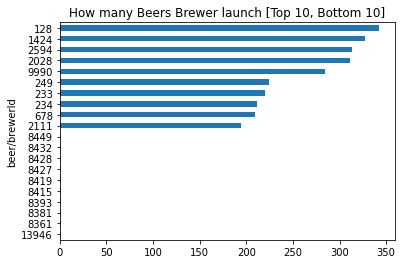

In [19]:
# 생산자의 맥주 생산 개수 분포 확인;  맥주 생산을 많이 하는 생산자와 별로 생산하지 않는 생산자와 같은 정보를 확인한다.
ratebeer.groupby(["beer/brewerId"])["beer/name"].nunique().sort_values(ascending=False).iloc[np.r_[0:10, -10:0]][::-1].plot(kind = 'barh')
plt.title("How many Beers Brewer launch [Top 10, Bottom 10]")
plt.show()

In [20]:
# 많게는 300개의 맥주를 발매한 회사부터, 1개의 맥주만 발매한 회사도 다수 존재한다.

In [21]:
# 그렇다면 혹시, 맥주를 많이 생산하는 생산자는 전체 리뷰수도 많을까?

top40brewers = ratebeer.groupby(["beer/brewerId"])["beer/name"].nunique().sort_values(ascending=False).head(40).index
brewer_reviews = ratebeer.value_counts("beer/brewerId").reset_index()
brewer_reviews.columns = ["beer/brewerId", "freq"]

brewer_reviews["top40brewer"] = brewer_reviews["beer/brewerId"].isin(top40brewers)
brewer_reviews.sort_values("freq", ascending=False, inplace=True)

brewer_reviews["top40brewer"] = np.where(brewer_reviews["top40brewer"], brewer_reviews["freq"], 0)
brewer_reviews["normal"] = np.where(brewer_reviews["top40brewer"]==False, brewer_reviews["freq"], 0)
brewer_reviews.head()

,beer/brewerId,freq,top40brewer,normal
0,32,46566,46566,0
1,76,38663,0,38663
2,198,37364,0,37364
3,96,35151,0,35151
4,232,32433,32433,0


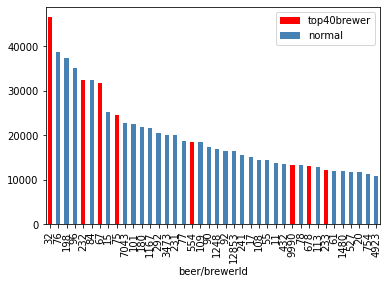

In [22]:
brewer_reviews.drop("freq", axis= 1).set_index("beer/brewerId").head(40).plot(kind = 'bar',  stacked=True, color=['red', 'steelblue', ])
plt.show()

In [23]:
# 맥주 발매량 상위 40개 회사가 모두, 많은 리뷰수를 만들어내지는 못하는 것을 확인할 수 있다.
# 하지만, 맥주 발매량 상위 40개 생산자 내에 많은 수준의 생산자들을 나타내는 것으로 보인다.
# 정리하자면, 어느정도 상관관계가 없다고 할 수 있을지는 모르겠지만, 완전한 경향성을 나타내는 것으로는 보이지 않는다.

### beer/ABV - 맥주 알코올도수 탐색

In [24]:
# 알코올도수는 숫자 타입이여야하는데, 임포트될때, 자동으로 object 타입으로 변경되었던것으로 보아, str 타입의 정보가 포함되어있을수있다.
# 숫자가 아닌 값의 개수는?
abvs = pd.to_numeric(ratebeer["beer/ABV"], errors="coerce") # 숫자가 아닌 타입을 수치형으로 바꾸는데, 실제로 수치형으로 변환 불가한 타입의 정보는 NaN 처리를 해주는 명령어
print(f"[ratebeer] ABV(알코올 도수)에서 결측치('-') 리뷰 개수: {abvs.isna().sum(): 7,}개")
ratebeer["beer/ABV"] = abvs

[ratebeer] ABV(알코올 도수)에서 결측치('-') 리뷰 개수:  138,637개


In [25]:
# 저네 데이터 개수가 2,924,163개 인 것에 비해서 그렇게 높은 수치는 아닌것 같다. 

In [26]:
# 그렇다면, 몇 개의 맥주가 알코올 도수가 없을까?
n_missing_ABV = ratebeer[ratebeer["beer/ABV"].isna()]["beer/name"].nunique()
print(f"[ratebeer] ABV(알코올 도수)에서 결측치('-') 맥주 개수: {n_missing_ABV: 7,}개")


[ratebeer] ABV(알코올 도수)에서 결측치('-') 맥주 개수:  23,098개


In [27]:
# 전체 맥주의 개수가 110,299개 이므로, 전체 리뷰에서 결측치의 영향력 보다는 맥주 이름을 기준으로는 훨씬더 결측치의 비율측면에서 더 높은 것으로 보인다. 

In [28]:
# 기본 통계치부터 살펴보자
round(ratebeer["beer/ABV"].describe(), 3)

count    2785526.000
mean           6.641
std            2.314
min            0.010
25%            5.000
50%            6.000
75%            8.000
max           57.700
Name: beer/ABV, dtype: float64

In [29]:
# 맥주가, 알코올이 무려 57.700 까지 높은 것도 존재하고, 논알코올로 보이는것도 존재한다.

### beer/style - 맥주 스타일 종류 탐색

In [30]:
# beer/style 맥주 스타일 종류 탐색
n_style = ratebeer['beer/style'].nunique()
print(f"[ratebeer] 맥주의 스타일 종류: {n_style:,}가지")


[ratebeer] 맥주의 스타일 종류: 89가지


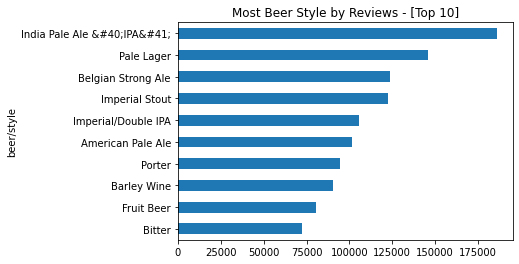

In [31]:
# 맥주 스타일에는 뭐가 있을까? 리뷰 횟수 기준, 가장 많은 맥주의 스타일과, 맥주 종류 기준으로 가장 많은 맥주의 스타일을 구해본다. 
# 리뷰 기준, 맥주 스타일 top N
ratebeer.value_counts("beer/style").head(10)[::-1].plot(kind = "barh")
plt.title("Most Beer Style by Reviews - [Top 10]")
plt.show()

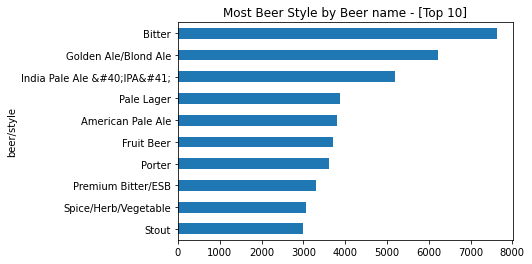

In [32]:
# 맥주 종류 기준, 맥주 스타일 top N
ratebeer.groupby("beer/style")["beer/name"].nunique().sort_values(ascending=False).head(10)[::-1].plot(kind="barh")
plt.title("Most Beer Style by Beer name - [Top 10]")
plt.show()

In [33]:
set_top10_style_by_review = set(ratebeer.value_counts("beer/style").head(10).index)
set_top10_style_by_name = set(ratebeer.groupby("beer/style")["beer/name"].nunique().sort_values(ascending=False).head(10).index)
print(f"[ratebeer] 공통으로 많이 나오는 맥주 스타일 6가지 = {list(set_top10_style_by_review.intersection(set_top10_style_by_name))}")

[ratebeer] 공통으로 많이 나오는 맥주 스타일 6가지 = ['American Pale Ale', 'Bitter', 'Porter', 'India Pale Ale &#40;IPA&#41;', 'Fruit Beer', 'Pale Lager']


In [34]:
# 인기 있는 종류들은 역시나, 거기에서 거기이다. 
# 여기서 India Pale Ale &#40;IPA&#41; 의 명칭으로한 스타일이 궁금한데, 나중에 찾아봐야겠다...

## Score!!!
- `review/appearance`: 평가점수-외관(look) 
- `review/aroma`: 평가점수-향기(smell)
- `review/palate`: 평가점수-the sense of taste(feel)
- `review/taste`: 평가점수-맛
- `review/overall`: 평가점수-종합

### review/appearance
- 5점 척도

In [35]:
# 점수 변환
temp_appearance = list(map(lambda x: x[:-2] if "/" in x else "-", ratebeer["review/appearance"]))
ratebeer["review/appearance"] = pd.to_numeric(temp_appearance, errors="coerce")

In [36]:
# 기본 통계치
round(ratebeer["review/appearance"].describe(),3)

count    2924163.000
mean           3.432
std            0.813
min            1.000
25%            3.000
50%            3.000
75%            4.000
max            5.000
Name: review/appearance, dtype: float64

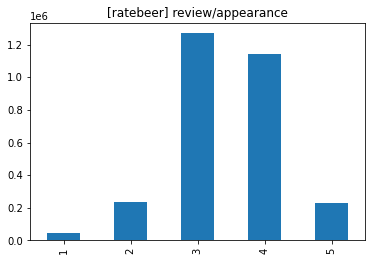

In [37]:
ratebeer["review/appearance"].value_counts().sort_index().plot(kind = "bar")
plt.title("[ratebeer] review/appearance")
plt.show()

### review/aroma
- 10점 척도

In [38]:
# 점수 변환
temp_aroma = list(map(lambda x: x[:-3] if "/" in x else "-", ratebeer["review/aroma"]))
ratebeer["review/aroma"] = pd.to_numeric(temp_aroma, errors="coerce")

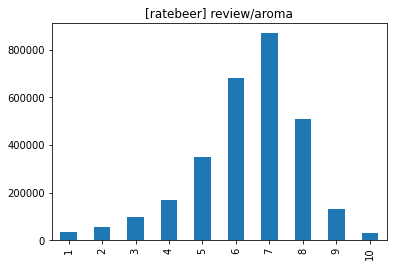

In [39]:
ratebeer["review/aroma"].value_counts().sort_index().plot(kind = "bar")
plt.title("[ratebeer] review/aroma")
plt.show()

### review/palateb
- 5점 척도

In [40]:
# 점수 변환
temp_palate = list(map(lambda x: x[:-2] if "/" in x else "-", ratebeer["review/palate"]))
ratebeer["review/palate"] = pd.to_numeric(temp_palate, errors="coerce")

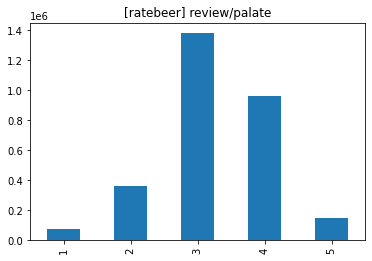

In [41]:
ratebeer["review/palate"].value_counts().sort_index().plot(kind = "bar")
plt.title("[ratebeer] review/palate")
plt.show()

### review/taste
- 10점 척도

In [42]:
# 점수 변환
temp_taste = list(map(lambda x: x[:-3] if "/" in x else "-", ratebeer["review/taste"]))
ratebeer["review/taste"] = pd.to_numeric(temp_taste, errors="coerce")

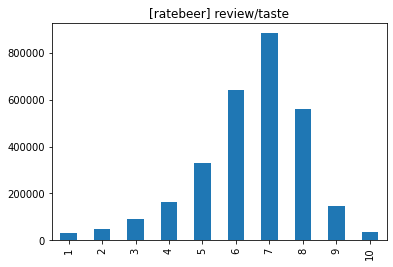

In [43]:
ratebeer["review/taste"].value_counts().sort_index().plot(kind = "bar")
plt.title("[ratebeer] review/taste")
plt.show()

### review/overall
- 20점 척도

In [44]:
# 점수 변환
temp_overall = list(map(lambda x: x[:-3] if "/" in x else "-", ratebeer["review/overall"]))
ratebeer["review/overall"] = pd.to_numeric(temp_overall, errors="coerce")

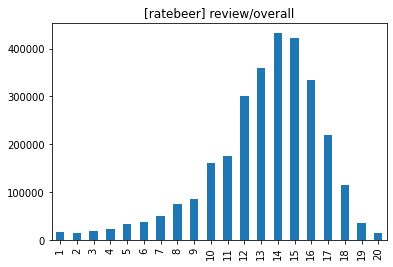

In [45]:
ratebeer["review/overall"].value_counts().sort_index().plot(kind = "bar")
plt.title("[ratebeer] review/overall")
plt.show()

In [46]:
# 척도에 따라, 어느값에 사람들이 많이 체크를 하는지 알 수 있다. 
# 5점 척도인 경우에는 3점을 많이 주는 경향이 있는 것을 볼 수 있고, 
# 10점척도인 경우게는 7점, 20점 척도에서는 10점 척도로 변경한다면 매우 비슷한 형태를 취하는 것을 알 수 있다.

# Further Works
    # 이것을 통해서 사람들은 점수를 매기는 것에 큰 의미를 두고 있지 않고, 보통 후한 값을 주는 것으로 보인다. 
    # 물론 그것을 넘기고 말고가 중요한 Key point가 될 수 있다고 생각한다.
    # 앞으로 수집하는 데이터에서는 이러한 정보를 유저로부터 수집하기 어려워지는데, 이런 문제를 해결하기 해당 데이터를 어떻게 사용할지도 고려해봐야한다.
        # ex Preference의 Confidence 인자로 활용하여, 선호 비선호 구별?
    # overall 에서 유저의 평가가 올바르게 이루어질 경우, 

### review/time

- timedelta 형태로 날짜가 기록되어있다.
- 구체적인 시간대는 기록되어있지 않았다. 

In [47]:
ratebeer_datetime = ratebeer['review/time'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x) ))
ratebeer_datetime

0          2006-09-07 00:00:00
1          2006-09-03 00:00:00
2          2000-05-19 00:00:00
3          2006-09-07 00:00:00
4          2006-09-07 00:00:00
                  ...         
2924158    2002-02-15 00:00:00
2924159    2004-01-23 00:00:00
2924160    2003-04-20 00:00:00
2924161    2002-03-18 00:00:00
2924162    2001-09-12 00:00:00
Name: review/time, Length: 2924163, dtype: object

In [48]:
print(f"[ratebeer] 리뷰 기록 기간 {ratebeer_datetime.min()} ~ {ratebeer_datetime.max()}")

[ratebeer] 리뷰 기록 기간 2000-04-12 00:00:00 ~ 2012-01-13 00:00:00


In [49]:
# 시간 데이터 탐색 | 시간 정보에 의한 인사이트 확보
df_dt = pd.DataFrame()
df_dt["dt"] = ratebeer_datetime.apply(lambda x: datetime.fromisoformat(x))
df_dt["date"] = df_dt["dt"].apply(lambda x: str(x.date()))
df_dt["year"] = df_dt["dt"].apply(lambda x: x.year)
df_dt["month"] = df_dt["dt"].apply(lambda x: x.month)
df_dt["day"] = df_dt["dt"].apply(lambda x: x.day)
df_dt["weekday"] = df_dt["dt"].apply(lambda x: x.weekday())

# 시간이 너무 많이 소요된다. 해결 방안은?

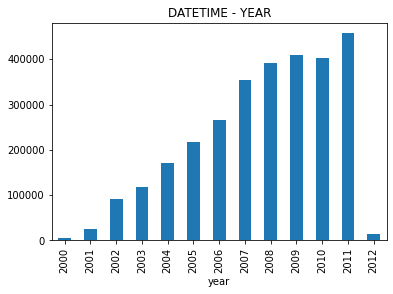

In [50]:
df_dt.value_counts("year").sort_index().plot(kind = "bar")
plt.title("DATETIME - YEAR")
plt.show()

In [51]:
# 아마도 서비스가 성장함에 따라 기록이 늘었을 가능성이 높다.
# 추후에 Benchmark dataset을 어떻게 구성할지 고려해볼 수 있는 부분이 되겠다.

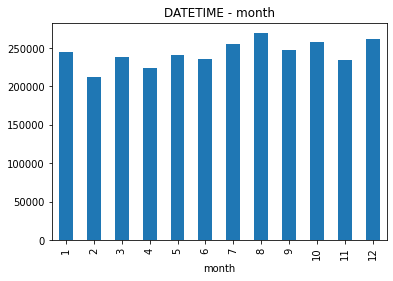

In [52]:
df_dt.value_counts("month").sort_index().plot(kind = "bar")
plt.title("DATETIME - month")
plt.show()

In [53]:
# 외국 데이터로, 사계절이 뚜렷해서 여름-맥주 를 연결시켜서 상품화 하는 우리나라와는 달리
# 사계절이 불분명하기 때문에 어떤 시즌에 맥주가 많이 소비되고 그런 경향성은 보이지 않는 것 같다.

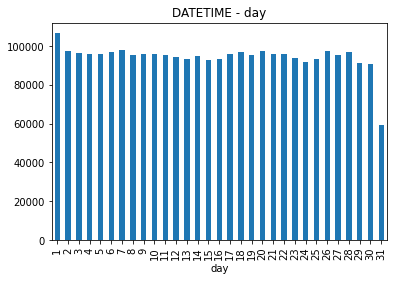

In [54]:
df_dt.value_counts("day").sort_index().plot(kind = "bar")
plt.title("DATETIME - day")
plt.show()

In [55]:
# 마찬가지로, 날짜는 어떠한 경향성도 존재하지 않는 것으로 보인다. 다만, 1일은 조금 많은 소비가 있는 것으로 보인다. 

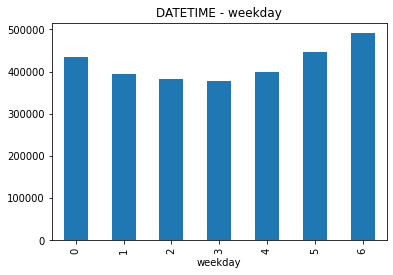

In [56]:
df_dt.value_counts("weekday").sort_index().plot(kind = "bar")
plt.title("DATETIME - weekday")
plt.show()

In [57]:
# 확실히 금요일, 토요일에 맥주 리뷰를 많이 하는 것으로 나타난다. 
# 다른 날도 충분히 많이 보고 있지만, 일요일을 제외한 주말로 갈 수록 리뷰의 수가 증가하는 추세를 볼 수 있다.

### review/profileName

In [58]:
n_user = ratebeer['review/profileName'].nunique()
print(f"[ratebeer] 유저의 수: {n_user:,}")

[ratebeer] 유저의 수: 29,265


In [59]:
# sparsity
print(f"[ratebeer] Sparsity: {1-n_data/(n_item*n_user):2.3%} | Density: {n_data/(n_item*n_user):2.3%}")

[ratebeer] Sparsity: 99.909% | Density: 0.091%


<AxesSubplot:>

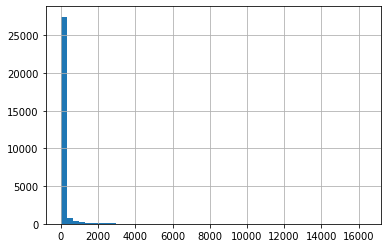

In [60]:
# 한 명의 유저가 남긴 리뷰의 수 분포는?
ratebeer.value_counts("review/profileName").hist(bins = 50)

In [61]:
# 대부분이 적은 리뷰 수를 남긴다. (일반인)
# (생각해볼점) 적은 리뷰를 남긴 유저의 데이터가 추천 모델을 학습시키기에 적합할까? 
#       -> 어떻게 처리할 수 있을까? 그래도 양질의 정성이 담긴 평가가 있다면, 그것은 해당 아이템에 대한 평가에 소중한 의견이 될 수 있다.
# 하지만, 역시나, 무언가를 추천해주기에는, 해당 유저의 특성을 하나의 맥주만으로 파악할 수 없기 때문에, 어렵다.
# 하지만, 해당 데이터는 리뷰를 가지고 있으므로, 리뷰 글을 통해서 비슷한 유저인지 아닌지 좀 파악알 수 있지 않을까?

<AxesSubplot:>

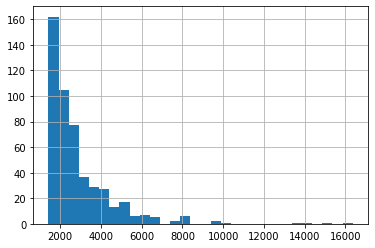

In [62]:
# 리뷰 개수 상위 500명에 대한 분포
ratebeer.value_counts("review/profileName")[:500].hist(bins = 30)

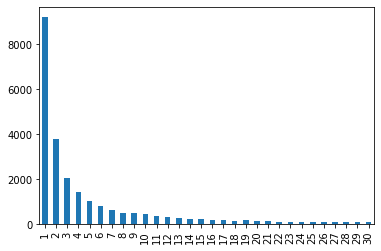

1    9215
2    3777
3    2065
4    1442
5    1023
dtype: int64

In [63]:
# 리뷰를 적게 남긴 유저의 기준으로 리뷰 개수별 몇 명이 있는지 분포를 확인해보자.
ratebeer.value_counts("review/profileName").value_counts().sort_index().head(30).plot(kind = "bar")
plt.show()
ratebeer.value_counts("review/profileName").value_counts().sort_index().head(5)

In [64]:
# 리뷰를 1개만 남긴 데이터는 전체에서 가장 많으며, 약 3만명의 유저 중에서, 약 1만명의 유저가 (약 30%) 단 하나의 리뷰만을 기록했을 뿐이다. 

In [65]:
# 리뷰를 남긴 개수의 기본 통계치
ratebeer.value_counts("review/profileName").describe()

count    29265.000000
mean        99.920144
std        465.198061
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max      16364.000000
dtype: float64

In [66]:
# 가장 많은 리뷰 수를 남긴 유저는 무려 16K 건의 리뷰를 남겼다. 중위수는 3개이다.

In [67]:
# (고민해야할 부분) 우리는 과연 몇 개의 리뷰를 남긴 데이터를 우리 추천에 활용할 수 있을지?
ratebeer.value_counts("review/profileName").value_counts(normalize=True)

1       0.314881
2       0.129062
3       0.070562
4       0.049274
5       0.034956
          ...   
1345    0.000034
1346    0.000034
1353    0.000034
1359    0.000034
831     0.000034
Length: 1460, dtype: float64

In [68]:
# 적은 리뷰 수를 기록하는 유저들을 제외하고 data의 sparsity 변화 추이를 확인해보자.
df_user = ratebeer.value_counts("review/profileName").reset_index()
df_user.columns = ["review/profileName", "freq"]
ratebeer = ratebeer.merge(df_user, on = "review/profileName")

df_user.head()

,review/profileName,freq
0,fonefan,16364
1,Ungstrup,15296
2,Papsoe,14170
3,yespr,13486
4,oh6gdx,9994


In [69]:
print("[ratebeer] 리뷰 개수가 N개 이하인 유저 제외")
print("|  N | SPARSITY | DENSITY |    SIZE   | # items | # users |")
# print("-----------------------------------------------------------")
for i in range(15):
    df_temp = ratebeer.query(f"freq > {i}")
    temp_n_item = df_temp["beer/name"].nunique()
    temp_n_user = df_temp["review/profileName"].nunique()
    temp_n_data = df_temp.shape[0]
    temp_density = temp_n_data/(temp_n_item*temp_n_user)
    print(f"| {i:2} | {1-temp_density:2.4%} | {temp_density:2.4%} | ", end = "")
    print(f"{temp_n_data:7,} | {temp_n_item:7,} | {temp_n_user:7,} |")

[ratebeer] 리뷰 개수가 N개 이하인 유저 제외
|  N | SPARSITY | DENSITY |    SIZE   | # items | # users |
|  0 | 99.9094% | 0.0906% | 2,924,163 | 110,299 |  29,265 |
|  1 | 99.8682% | 0.1318% | 2,914,948 | 110,268 |  20,050 |
|  2 | 99.8379% | 0.1621% | 2,907,394 | 110,237 |  16,273 |
|  3 | 99.8147% | 0.1853% | 2,901,199 | 110,207 |  14,208 |
|  4 | 99.7942% | 0.2058% | 2,895,431 | 110,190 |  12,766 |
|  5 | 99.7766% | 0.2234% | 2,890,316 | 110,172 |  11,743 |
|  6 | 99.7609% | 0.2391% | 2,885,594 | 110,165 |  10,956 |
|  7 | 99.7469% | 0.2531% | 2,881,233 | 110,154 |  10,333 |
|  8 | 99.7341% | 0.2659% | 2,877,161 | 110,145 |   9,824 |
|  9 | 99.7211% | 0.2789% | 2,872,913 | 110,140 |   9,352 |
| 10 | 99.7081% | 0.2919% | 2,868,633 | 110,133 |   8,924 |
| 11 | 99.6961% | 0.3039% | 2,864,607 | 110,127 |   8,558 |
| 12 | 99.6848% | 0.3152% | 2,860,815 | 110,121 |   8,242 |
| 13 | 99.6737% | 0.3263% | 2,857,045 | 110,110 |   7,952 |
| 14 | 99.6637% | 0.3363% | 2,853,615 | 110,107 |   7,707 |


In [70]:
# 적은 리뷰를 기록한 유저를 추천 시스템 모델을 학습시키는데에 제외해도 될 것같다. 
# 오직 유저의 수만 줄어든다.

# (고민 해야하는 내용)
# 적은 리뷰 수를 기록한 유저를 제외하는 것은 어떤 리스크가 존재할까?
# 잠재 고객들에게 우리는 유저가 마셔본 맥주 중에 10개 이상의 맥주에 대해서 평가를 요구할 예정이다. (10개 이상의 맥주를 마셔본 적이 없다면, 그냥 인기도 기반 추천을 할 수 밖에)
# 그래서 초기 유저에게서 10개 맥주에 대한 정보를 얻을 수 있다면, Cold-start problem이 어느정도 해결된 데이터만을 가지고 학습 시키는 것도 괜찮을것같다. 

# (EDA 에서 유저가 10개를 선택하지 못하는 상황도 고려해보자!)
# 하지만, 나의 뇌피셜로는, 우리가 실제로 고민해야할것은, 현실에서는 이렇게 유저에게 이러한 문제를 얻고자 하는 것도 어려운 일일 수 있다. 따라서, 
# 이런 부분만 고려해야할 것이 아니라, 실제로 맥주에 대한 경험이 별로 없다던지, 그런 이벤트가 있을 수 있다. 
# 그런 경우에도 추천해줄 수 있는 단순 모델이나 그런 방법들이 있다.


### review/text

In [71]:
print(f"전체 데이터의 길이  = {ratebeer.shape[0]:7,}")
nunique_reviewtext = ratebeer["review/text"].nunique()
print(f"review/text 개수 = {nunique_reviewtext:7,}")

전체 데이터의 길이  = 2,924,163
review/text 개수 = 2,844,800


In [72]:
# 리뷰는 모든 글이 다 달라야 정상이 아닌가? 그런데, 같은 리뷰가 있는것으로 보인다. 

In [74]:
# 약 10만개의 같은 리뷰는 어떤 리뷰들로 이루어져있을까?
ratebeer["review/text"].value_counts().where(lambda x: x>1).dropna()

                                                                                                                                                                                                                                                                                                                                                                                                                                                      5002.0
This beer is really pretty decent, but still nothing much to it.  I like some more complexity.                                                                                                                                                                                                                                                                                                                                                         199.0
This is part of a beer club. Had only one bottle but was decent for the price. Poured great and had a nice fin

In [77]:
# 엄청나게 많은 중복이 있는 텍스트가 있는것을 확인할 수 있다.
# 71,587 개의 유니크한 리뷰 텍스트가 약 10K 개의 중복된 리뷰를 만들어내었다.

In [76]:
# (Further Works) 정상적인 이용을 위해서 다음과 같은 것을 알아볼 필요가 있다고 판단된다.
# - 모든 중복 데이터에 대해서 이게 어떤 방식으로 작성된 것인지 파악해야한다. 
#   - 모두 같은 유저에 의해서 작성된 것인가?
#   - 밈 처럼 사용되는 것인가?
#   - 리뷰가 매우 많은 맥주에 대해서 발견되는 것인가?
#   - 리뷰가 같다면, 혹시 매크로에 의해서 작성된 것인가? (수치형 리뷰가 모두 같은 점수이거나 일정한 랜덤성을 따를 수 있다.)
# 
# - 3개 이하의 중복의 데이터에 대해서 
#   - 이전에 봤던 같은 맥주 이름을 공유하고 있는 서로 다음 맥주 일련번호가 혹시 같은 리뷰를 공유하고 있는 것은 아닐까?